In [24]:

!pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn torch -q

# Importing Libraries

In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import load_dataset
import os
from tqdm import tqdm
import json
from scipy import stats
!pip install -U transformers accelerate datasets



In [25]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [26]:

print("="*80)
print("STEP 1: LOADING DATASETS")
print("="*80)

# 1.1 Load English Training Data (IMDb)
print("\n📥 Loading English IMDb dataset...")
try:
    imdb_dataset = load_dataset("imdb")

    # Sample for faster training (remove sampling for full dataset)
    train_data = imdb_dataset['train'].shuffle(seed=42).select(range(5000))
    val_data = imdb_dataset['test'].shuffle(seed=42).select(range(1000))

    print(f"✅ English Training samples: {len(train_data)}")
    print(f"✅ English Validation samples: {len(val_data)}")
    print(f"Sample: {train_data[0]['text'][:100]}...")
    print(f"Label: {train_data[0]['label']} (0=Negative, 1=Positive)")
except Exception as e:
    print(f"❌ Error loading IMDb: {e}")
    print("Note: Run this on Kaggle with internet enabled")

# 1.2 Load Indic Language Test Data
print("\n📥 Loading Indic language datasets...")


STEP 1: LOADING DATASETS

📥 Loading English IMDb dataset...
✅ English Training samples: 5000
✅ English Validation samples: 1000
Sample: There is no relation at all between Fortier and Profiler but the fact that both are police series ab...
Label: 1 (0=Negative, 1=Positive)

📥 Loading Indic language datasets...


In [27]:
def create_sample_indic_data():
    """Create comprehensive sample Indic data for demonstration"""

    # HINDI SAMPLES (100 examples)
    hindi_positive = [
        'यह फिल्म बहुत अच्छी है',  # This movie is very good
        'शानदार अभिनय और कहानी',  # Great acting and story
        'बहुत रोमांचक और मनोरंजक',  # Very exciting and entertaining
        'मुझे यह फिल्म बहुत पसंद आई',  # I really liked this movie
        'कमाल की फिल्म है',  # Amazing movie
        'बेहतरीन निर्देशन और संगीत',  # Excellent direction and music
        'परिवार के साथ देखने लायक',  # Worth watching with family
        'सभी अभिनेताओं ने शानदार काम किया',  # All actors did great work
        'यह साल की सबसे अच्छी फिल्म है',  # This is the best movie of the year
        'मनोरंजक और प्रेरणादायक',  # Entertaining and inspiring
        'दिल को छू जाने वाली कहानी',  # Heart-touching story
        'बच्चों के लिए एकदम सही',  # Perfect for children
        'हर किसी को देखनी चाहिए',  # Everyone should watch
        'पैसा वसूल फिल्म',  # Value for money movie
        'धमाकेदार एक्शन सीन',  # Explosive action scenes
        'गाने बहुत सुंदर हैं',  # Songs are very beautiful
        'कहानी में नया ट्विस्ट',  # New twist in the story
        'विजुअल इफेक्ट्स कमाल के',  # Amazing visual effects
        'भावनात्मक और मार्मिक',  # Emotional and poignant
        'हास्य से भरपूर',  # Full of humor
        'रोमांस बहुत अच्छा है',  # Romance is very good
        'संदेश देने वाली फिल्म',  # Message-oriented movie
        'यादगार फिल्म बन गई',  # Became a memorable movie
        'सिनेमाघरों में जरूर देखें',  # Must watch in theaters
        'पूरे परिवार का मनोरंजन',  # Entertainment for whole family
        'बेहतरीन पटकथा',  # Excellent screenplay
        'अभिनय की बेहतरीन मिसाल',  # Great example of acting
        'सिनेमेटोग्राफी शानदार है',  # Cinematography is wonderful
        'संवाद बहुत प्रभावी हैं',  # Dialogues are very effective
        'क्लाइमेक्स धमाकेदार',  # Climax is explosive
        'सस्पेंस बना रहता है',  # Suspense is maintained
        'रोने पर मजबूर कर देगी',  # Will make you cry
        'हंसाने में कामयाब',  # Successful in making laugh
        'प्रेम कहानी दिल को छू गई',  # Love story touched the heart
        'देखते ही रहोगे',  # You'll keep watching
        'समय बीतने का पता नहीं चला',  # Didn't realize time passing
        'सभी उम्र के लोगों के लिए',  # For all age groups
        'बॉलीवुड की शान',  # Pride of Bollywood
        'ब्लॉकबस्टर फिल्म',  # Blockbuster movie
        'हिट होने वाली फिल्म',  # Movie that will be a hit
        'दोबारा देखने लायक',  # Worth watching again
        'पूरी तरह मनोरंजक',  # Completely entertaining
        'गजब की फिल्म है',  # Awesome movie
        'लाजवाब प्रस्तुति',  # Marvelous presentation
        'दमदार अभिनय',  # Powerful acting
        'रोमांच से भरा अनुभव',  # Thrilling experience
        'यथार्थवादी चित्रण',  # Realistic portrayal
        'सामाजिक संदेश के साथ',  # With social message
        'मास्टरपीस फिल्म',  # Masterpiece movie
        'हर दृश्य शानदार',  # Every scene is wonderful
    ]

    hindi_negative = [
        'मुझे यह फिल्म पसंद नहीं आई',  # I didn't like this movie
        'बेकार फिल्म समय की बर्बादी',  # Bad movie waste of time
        'कहानी बहुत कमजोर है',  # Story is very weak
        'उबाऊ और लंबी फिल्म',  # Boring and long movie
        'पैसे का बर्बाद',  # Waste of money
        'अभिनय बिल्कुल नहीं जमा',  # Acting didn't work at all
        'निर्देशन में कमी',  # Lack in direction
        'संगीत भी अच्छा नहीं',  # Music is also not good
        'देखने लायक नहीं',  # Not worth watching
        'समय खराब हो गया',  # Time got wasted
        'कोई नयापन नहीं',  # Nothing new
        'पुरानी कहानी फिर से',  # Old story again
        'बच्चों को मत दिखाना',  # Don't show to children
        'बहुत निराशाजनक',  # Very disappointing
        'एक्शन भी बेकार',  # Action also useless
        'गाने कानों को तकलीफ',  # Songs hurt the ears
        'ट्विस्ट का अभाव',  # Lack of twist
        'विजुअल इफेक्ट्स घटिया',  # Poor visual effects
        'भावनात्मक रूप से कमजोर',  # Emotionally weak
        'हास्य फीका है',  # Comedy is bland
        'रोमांस जबरदस्ती का',  # Forced romance
        'कोई संदेश नहीं',  # No message
        'भूलने योग्य फिल्म',  # Forgettable movie
        'घर पर भी मत देखें',  # Don't watch even at home
        'परिवार के साथ शर्मिंदगी',  # Embarrassment with family
        'पटकथा में छेद',  # Holes in screenplay
        'अभिनय बनावटी लगा',  # Acting seemed artificial
        'सिनेमेटोग्राफी औसत',  # Average cinematography
        'संवाद बचकाने हैं',  # Dialogues are childish
        'क्लाइमेक्स निराश करता है',  # Climax disappoints
        'सस्पेंस बिल्कुल नहीं',  # No suspense at all
        'रुलाने में नाकाम',  # Failed to make cry
        'हंसाने की कोशिश फेल',  # Failed attempt to make laugh
        'प्रेम कहानी घिसी पिटी',  # Love story is cliched
        'देखते हुए नींद आई',  # Felt sleepy while watching
        'समय बर्बाद हो गया',  # Time got wasted
        'बच्चों को बोर करेगी',  # Will bore children
        'बॉलीवुड की सबसे खराब',  # Worst of Bollywood
        'फ्लॉप होने वाली फिल्म',  # Movie that will flop
        'एक बार भी मत देखो',  # Don't watch even once
        'पूरी तरह बेकार',  # Completely useless
        'घटिया फिल्म है',  # Poor quality movie
        'बुरी प्रस्तुति',  # Bad presentation
        'कमजोर अभिनय',  # Weak acting
        'रोमांच का अभाव',  # Lack of thrill
        'अवास्तविक चित्रण',  # Unrealistic portrayal
        'व्यर्थ का सामाजिक संदेश',  # Useless social message
        'असफल फिल्म',  # Failed movie
        'हर दृश्य उबाऊ',  # Every scene is boring
    ]

    hindi_data = pd.DataFrame({
        'text': hindi_positive + hindi_negative,
        'label': [1] * len(hindi_positive) + [0] * len(hindi_negative)
    })

    # TELUGU SAMPLES (100 examples)
    telugu_positive = [
        'ఈ సినిమా చాలా బాగుంది',  # This movie is very good
        'అద్భుతమైన నటన మరియు కథ',  # Wonderful acting and story
        'చాలా ఉత్తేజకరమైన',  # Very exciting
        'నాకు ఈ సినిమా చాలా నచ్చింది',  # I really liked this movie
        'అద్భుతమైన సినిమా',  # Amazing movie
        'గొప్ప దర్శకత్వం మరియు సంగీతం',  # Great direction and music
        'కుటుంబంతో చూడదగినది',  # Worth watching with family
        'అందరు నటీనటులు అద్భుతంగా నటించారు',  # All actors acted wonderfully
        'ఈ సంవత్సరపు ఉత్తమ చిత్రం',  # Best movie of the year
        'వినోదభరితం మరియు స్ఫూర్తిదాయకం',  # Entertaining and inspiring
        'హృదయాన్ని తాకే కథ',  # Heart-touching story
        'పిల్లలకు సరిపోయేది',  # Perfect for children
        'అందరూ తప్పక చూడాలి',  # Everyone must watch
        'డబ్బు విలువైనది',  # Value for money
        'అద్భుతమైన యాక్షన్ సీన్లు',  # Amazing action scenes
        'పాటలు చాలా అందంగా ఉన్నాయి',  # Songs are very beautiful
        'కథలో కొత్త ట్విస్ట్',  # New twist in story
        'విజువల్ ఎఫెక్ట్స్ అద్భుతమైనవి',  # Visual effects are amazing
        'భావోద్వేగభరితమైనది',  # Emotional
        'హాస్యంతో నిండినది',  # Full of humor
        'ప్రేమకథ చాలా బాగుంది',  # Love story is very good
        'సందేశాన్ని ఇచ్చే సినిమా',  # Message-giving movie
        'మరపురాని సినిమా',  # Unforgettable movie
        'థియేటర్లలో తప్పక చూడాలి',  # Must watch in theaters
        'మొత్తం కుటుంబానికి వినోదం',  # Entertainment for whole family
        'అద్భుతమైన స్క్రీన్‌ప్లే',  # Excellent screenplay
        'నటన యొక్క గొప్ప ఉదాహరణ',  # Great example of acting
        'సినిమాటోగ్రఫీ అద్భుతమైనది',  # Cinematography is wonderful
        'డైలాగ్స్ చాలా ప్రభావవంతమైనవి',  # Dialogues are very effective
        'క్లైమాక్స్ అద్భుతమైనది',  # Climax is amazing
        'సస్పెన్స్ కొనసాగుతుంది',  # Suspense continues
        'ఏడ్పించేలా ఉంది',  # Makes you cry
        'నవ్వించడంలో విజయవంతం',  # Successful in making laugh
        'ప్రేమకథ హృదయాన్ని తాకింది',  # Love story touched heart
        'చూస్తూనే ఉంటారు',  # You'll keep watching
        'సమయం గడిచిందని తెలియలేదు',  # Didn't realize time passing
        'అన్ని వయసుల వారికి',  # For all ages
        'తెలుగు సినిమా గర్వం',  # Pride of Telugu cinema
        'బ్లాక్‌బస్టర్ సినిమా',  # Blockbuster movie
        'హిట్ అయ్యే సినిమా',  # Movie that will be hit
        'మళ్ళీ చూడదగినది',  # Worth watching again
        'పూర్తిగా వినోదభరితం',  # Completely entertaining
        'అద్భుతమైన సినిమా',  # Awesome movie
        'అద్భుతమైన ప్రదర్శన',  # Marvelous presentation
        'శక్తివంతమైన నటన',  # Powerful acting
        'థ్రిల్లింగ్ అనుభవం',  # Thrilling experience
        'వాస్తవిక చిత్రణ',  # Realistic portrayal
        'సామాజిక సందేశంతో',  # With social message
        'మాస్టర్‌పీస్ సినిమా',  # Masterpiece movie
        'ప్రతి సన్నివేశం అద్భుతం',  # Every scene is wonderful
    ]

    telugu_negative = [
        'నాకు ఈ సినిమా నచ్చలేదు',  # I didn't like this movie
        'వ్యర్థ సినిమా',  # Waste movie
        'కథ చాలా బలహీనంగా ఉంది',  # Story is very weak
        'బోరింగ్ మరియు పొడవైన సినిమా',  # Boring and long movie
        'డబ్బు వృథా',  # Waste of money
        'నటన బిల్కుల్ జమలేదు',  # Acting didn't work at all
        'దర్శకత్వంలో లోపం',  # Lack in direction
        'సంగీతం కూడా బాగోలేదు',  # Music is also not good
        'చూడదగినది కాదు',  # Not worth watching
        'సమయం వృథా అయింది',  # Time got wasted
        'ఏమీ కొత్తది లేదు',  # Nothing new
        'పాత కథ మళ్ళీ',  # Old story again
        'పిల్లలకు చూపించవద్దు',  # Don't show to children
        'చాలా నిరాశపరిచింది',  # Very disappointing
        'యాక్షన్ కూడా వ్యర్థం',  # Action also useless
        'పాటలు చెవులకు బాధ',  # Songs hurt the ears
        'ట్విస్ట్ లేదు',  # No twist
        'విజువల్ ఎఫెక్ట్స్ చెత్త',  # Poor visual effects
        'భావోద్వేగంగా బలహీనం',  # Emotionally weak
        'హాస్యం చప్పగా ఉంది',  # Comedy is bland
        'బలవంతపు రొమాన్స్',  # Forced romance
        'ఎలాంటి సందేశం లేదు',  # No message
        'మర్చిపోయే సినిమా',  # Forgettable movie
        'ఇంట్లో కూడా చూడవద్దు',  # Don't watch even at home
        'కుటుంబంతో ఇబ్బంది',  # Embarrassment with family
        'స్క్రీన్‌ప్లేలో రంధ్రాలు',  # Holes in screenplay
        'నటన కృత్రిమంగా ఉంది',  # Acting seemed artificial
        'సినిమాటోగ్రఫీ సగటు',  # Average cinematography
        'డైలాగ్స్ పిల్లతనంగా ఉన్నాయి',  # Dialogues are childish
        'క్లైమాక్స్ నిరాశపరుస్తుంది',  # Climax disappoints
        'సస్పెన్స్ బిల్కుల్ లేదు',  # No suspense at all
        'ఏడ్పించడంలో విఫలం',  # Failed to make cry
        'నవ్వించే ప్రయత్నం విఫలం',  # Failed attempt to make laugh
        'ప్రేమకథ క్లిష్టమైనది',  # Love story is cliched
        'చూస్తూ నిద్ర వచ్చింది',  # Felt sleepy while watching
        'సమయం వృథా అయింది',  # Time got wasted
        'పిల్లలను బోర్ చేస్తుంది',  # Will bore children
        'తెలుగు సినిమాలో చెత్త',  # Worst of Telugu cinema
        'ఫ్లాప్ అయ్యే సినిమా',  # Movie that will flop
        'ఒక్కసారి కూడా చూడవద్దు',  # Don't watch even once
        'పూర్తిగా వ్యర్థం',  # Completely useless
        'చెత్త సినిమా',  # Poor quality movie
        'చెడ్డ ప్రదర్శన',  # Bad presentation
        'బలహీనమైన నటన',  # Weak acting
        'థ్రిల్ లేదు',  # No thrill
        'అవాస్తవిక చిత్రణ',  # Unrealistic portrayal
        'వ్యర్థమైన సామాజిక సందేశం',  # Useless social message
        'విఫలమైన సినిమా',  # Failed movie
        'ప్రతి సన్నివేశం బోరింగ్',  # Every scene is boring
    ]

    telugu_data = pd.DataFrame({
        'text': telugu_positive + telugu_negative,
        'label': [1] * len(telugu_positive) + [0] * len(telugu_negative)
    })

    # TAMIL SAMPLES (100 examples)
    tamil_positive = [
        'இந்த திரைப்படம் மிகவும் நன்றாக உள்ளது',  # This movie is very good
        'அருமையான நடிப்பு மற்றும் கதை',  # Great acting and story
        'மிகவும் சுவாரஸ்யமான',  # Very interesting
        'எனக்கு இந்த படம் மிகவும் பிடித்திருந்தது',  # I really liked this movie
        'அற்புதமான திரைப்படம்',  # Amazing movie
        'சிறந்த இயக்கம் மற்றும் இசை',  # Great direction and music
        'குடும்பத்துடன் பார்க்க தகுந்தது',  # Worth watching with family
        'அனைத்து நடிகர்களும் அருமையாக நடித்துள்ளனர்',  # All actors acted wonderfully
        'இந்த ஆண்டின் சிறந்த படம்',  # Best movie of the year
        'பொழுதுபோக்கு மற்றும் ஊக்கமளிக்கும்',  # Entertaining and inspiring
        'இதயத்தைத் தொடும் கதை',  # Heart-touching story
        'குழந்தைகளுக்கு ஏற்றது',  # Perfect for children
        'அனைவரும் கண்டிப்பாக பார்க்க வேண்டும்',  # Everyone must watch
        'பணத்திற்கு மதிப்புள்ளது',  # Value for money
        'அற்புதமான ஆக்ஷன் காட்சிகள்',  # Amazing action scenes
        'பாடல்கள் மிகவும் அழகாக உள்ளன',  # Songs are very beautiful
        'கதையில் புதிய திருப்பம்',  # New twist in story
        'விஷுவல் எஃபெக்ட்ஸ் அற்புதமானவை',  # Visual effects are amazing
        'உணர்ச்சிகரமானது',  # Emotional
        'நகைச்சுவையால் நிரப்பப்பட்டது',  # Full of humor
        'காதல் கதை மிகவும் நன்றாக உள்ளது',  # Love story is very good
        'செய்தி கொடுக்கும் படம்',  # Message-giving movie
        'மறக்க முடியாத படம்',  # Unforgettable movie
        'திரையரங்குகளில் கண்டிப்பாக பார்க்க வேண்டும்',  # Must watch in theaters
        'முழு குடும்பத்திற்கும் பொழுதுபோக்கு',  # Entertainment for whole family
        'அற்புதமான திரைக்கதை',  # Excellent screenplay
        'நடிப்பின் சிறந்த உதாரணம்',  # Great example of acting
        'ஒளிப்பதிவு அற்புதமானது',  # Cinematography is wonderful
        'வசனங்கள் மிகவும் பயனுள்ளவை',  # Dialogues are very effective
        'க்ளைமாக்ஸ் அற்புதமானது',  # Climax is amazing
        'சஸ்பென்ஸ் தொடர்கிறது',  # Suspense continues
        'அழ வைக்கும்',  # Makes you cry
        'சிரிக்க வைப்பதில் வெற்றி',  # Successful in making laugh
        'காதல் கதை இதயத்தைத் தொட்டது',  # Love story touched heart
        'பார்த்துக் கொண்டே இருப்பீர்கள்',  # You'll keep watching
        'நேரம் கடந்ததே தெரியவில்லை',  # Didn't realize time passing
        'அனைத்து வயதினருக்கும்',  # For all ages
        'தமிழ் சினிமாவின் பெருமை',  # Pride of Tamil cinema
        'பிளாக்பஸ்டர் படம்',  # Blockbuster movie
        'ஹிட் ஆகும் படம்',  # Movie that will be hit
        'மீண்டும் பார்க்க தகுந்தது',  # Worth watching again
        'முற்றிலும் பொழுதுபோக்கு',  # Completely entertaining
        'அற்புதமான படம்',  # Awesome movie
        'அற்புதமான விளக்கக்காட்சி',  # Marvelous presentation
        'சக்திவாய்ந்த நடிப்பு',  # Powerful acting
        'த்ரில்லிங் அனுபவம்',  # Thrilling experience
        'யதார்த்தமான சித்தரிப்பு',  # Realistic portrayal
        'சமூக செய்தியுடன்',  # With social message
        'மாஸ்டர்பீஸ் படம்',  # Masterpiece movie
        'ஒவ்வொரு காட்சியும் அற்புதம்',  # Every scene is wonderful
    ]

    tamil_negative = [
        'எனக்கு இந்த படம் பிடிக்கவில்லை',  # I didn't like this movie
        'மோசமான படம்',  # Bad movie
        'கதை மிகவும் பலவீனமாக உள்ளது',  # Story is very weak
        'சலிப்பான மற்றும் நீண்ட படம்',  # Boring and long movie
        'பணம் வீணாகிவிட்டது',  # Money wasted
        'நடிப்பு சரியில்லை',  # Acting didn't work
        'இயக்கத்தில் குறைபாடு',  # Lack in direction
        'இசையும் நன்றாக இல்லை',  # Music is also not good
        'பார்க்க தகுதியற்றது',  # Not worth watching
        'நேரம் வீணாகிவிட்டது',  # Time got wasted
        'புதிதாக எதுவும் இல்லை',  # Nothing new
        'பழைய கதை மீண்டும்',  # Old story again
        'குழந்தைகளுக்கு காட்ட வேண்டாம்',  # Don't show to children
        'மிகவும் ஏமாற்றமளிக்கிறது',  # Very disappointing
        'ஆக்ஷன் கூட வீணானது',  # Action also useless
        'பாடல்கள் காதுகளுக்கு வலி',  # Songs hurt the ears
        'திருப்பம் இல்லை',  # No twist
        'விஷுவல் எஃபெக்ட்ஸ் மோசம்',  # Poor visual effects
        'உணர்ச்சிபூர்வமாக பலவீனம்',  # Emotionally weak
        'நகைச்சுவை சுவையற்றது',  # Comedy is bland
        'கட்டாயமான காதல்',  # Forced romance
        'எந்த செய்தியும் இல்லை',  # No message
        'மறந்துவிடக்கூடிய படம்',  # Forgettable movie
        'வீட்டிலும் பார்க்க வேண்டாம்',  # Don't watch even at home
        'குடும்பத்துடன் சங்கடம்',  # Embarrassment with family
        'திரைக்கதையில் துளைகள்',  # Holes in screenplay
        'நடிப்பு செயற்கையாக இருந்தது',  # Acting seemed artificial
        'ஒளிப்பதிவு சராசரி',  # Average cinematography
        'வசனங்கள் குழந்தைத்தனமானவை',  # Dialogues are childish
        'க்ளைமாக்ஸ் ஏமாற்றமளிக்கிறது',  # Climax disappoints
        'சஸ்பென்ஸ் இல்லவே இல்லை',  # No suspense at all
        'அழ வைப்பதில் தோல்வி',  # Failed to make cry
        'சிரிக்க வைக்கும் முயற்சி தோல்வி',  # Failed attempt to make laugh
        'காதல் கதை பழையதாக உள்ளது',  # Love story is cliched
        'பார்க்கும்போது தூக்கம் வந்தது',  # Felt sleepy while watching
        'நேரம் வீணாகிவிட்டது',  # Time got wasted
        'குழந்தைகளை சலிப்படையச் செய்யும்',  # Will bore children
        'தமிழ் சினிமாவின் மோசமானது',  # Worst of Tamil cinema
        'தோல்வியடையும் படம்',  # Movie that will flop
        'ஒரு முறை கூட பார்க்க வேண்டாம்',  # Don't watch even once
        'முற்றிலும் வீணானது',  # Completely useless
        'மோசமான படம்',  # Poor quality movie
        'மோசமான விளக்கக்காட்சி',  # Bad presentation
        'பலவீனமான நடிப்பு',  # Weak acting
        'த்ரில் இல்லை',  # No thrill
        'நடைமுறைக்கு மாறான சித்தரிப்பு',  # Unrealistic portrayal
        'பயனற்ற சமூக செய்தி',  # Useless social message
        'தோல்வியடைந்த படம்',  # Failed movie
        'ஒவ்வொரு காட்சியும் சலிப்பூட்டுகிறது',  # Every scene is boring
    ]

    tamil_data = pd.DataFrame({
        'text': tamil_positive + tamil_negative,
        'label': [1] * len(tamil_positive) + [0] * len(tamil_negative)
    })

    # Shuffle the data
    hindi_data = hindi_data.sample(frac=1, random_state=42).reset_index(drop=True)
    telugu_data = telugu_data.sample(frac=1, random_state=42).reset_index(drop=True)
    tamil_data = tamil_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Print statistics
    print("\n📊 Dataset Statistics:")
    print(f"   Hindi: {len(hindi_data)} samples ({hindi_data['label'].sum()} positive, {len(hindi_data) - hindi_data['label'].sum()} negative)")
    print(f"   Telugu: {len(telugu_data)} samples ({telugu_data['label'].sum()} positive, {len(telugu_data) - telugu_data['label'].sum()} negative)")
    print(f"   Tamil: {len(tamil_data)} samples ({tamil_data['label'].sum()} positive, {len(tamil_data) - tamil_data['label'].sum()} negative)")

    return hindi_data, telugu_data, tamil_data

hindi_test, telugu_test, tamil_test = create_sample_indic_data()

print(f"✅ Hindi test samples: {len(hindi_test)}")
print(f"✅ Telugu test samples: {len(telugu_test)}")
print(f"✅ Tamil test samples: {len(tamil_test)}")




📊 Dataset Statistics:
   Hindi: 99 samples (50 positive, 49 negative)
   Telugu: 99 samples (50 positive, 49 negative)
   Tamil: 99 samples (50 positive, 49 negative)
✅ Hindi test samples: 99
✅ Telugu test samples: 99
✅ Tamil test samples: 99


In [28]:
# ============================================================================
# STEP 2: DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATA PREPROCESSING")
print("="*80)

def preprocess_text(text):
    """Minimal preprocessing for cross-lingual transfer"""
    import re
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
print("🔧 Applying minimal preprocessing...")

# Process English data
train_texts = [preprocess_text(x['text']) for x in train_data]
train_labels = [x['label'] for x in train_data]

val_texts = [preprocess_text(x['text']) for x in val_data]
val_labels = [x['label'] for x in val_data]

# Process Indic data
hindi_test['text'] = hindi_test['text'].apply(preprocess_text)
telugu_test['text'] = telugu_test['text'].apply(preprocess_text)
tamil_test['text'] = tamil_test['text'].apply(preprocess_text)

print("✅ Preprocessing complete")

# ============================================================================
# STEP 3: MODEL SELECTION & TOKENIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 3: MODEL SELECTION & TOKENIZATION")
print("="*80)

# Models to compare
MODELS = {
    'xlm-roberta-base': 'XLM-RoBERTa (Best cross-lingual)',
    'bert-base-multilingual-cased': 'mBERT (Baseline)',
    'ai4bharat/indic-bert': 'IndicBERT (Indic-focused)'
}

# Select model for this run (change to compare different models)
MODEL_NAME = 'xlm-roberta-base'  # Change this to test other models

print(f"\n🤖 Selected Model: {MODELS[MODEL_NAME]}")
print(f"Model ID: {MODEL_NAME}")

# Load tokenizer with proper handling for IndicBERT
print("📦 Loading tokenizer...")
if 'indic-bert' in MODEL_NAME:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize function
def tokenize_data(texts, labels, max_length=256):
    """Tokenize text data"""
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encodings, labels

# Tokenize datasets
print("🔤 Tokenizing datasets...")
train_encodings, train_labels_tensor = tokenize_data(train_texts, train_labels)
val_encodings, val_labels_tensor = tokenize_data(val_texts, val_labels)

# Create PyTorch datasets
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels_tensor)

print(f"✅ Train dataset size: {len(train_dataset)}")
print(f"✅ Validation dataset size: {len(val_dataset)}")


STEP 2: DATA PREPROCESSING
🔧 Applying minimal preprocessing...
✅ Preprocessing complete

STEP 3: MODEL SELECTION & TOKENIZATION

🤖 Selected Model: XLM-RoBERTa (Best cross-lingual)
Model ID: xlm-roberta-base
📦 Loading tokenizer...
🔤 Tokenizing datasets...
✅ Train dataset size: 5000
✅ Validation dataset size: 1000


In [29]:

# ============================================================================
# STEP 3: MODEL SELECTION & TOKENIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 3: MODEL SELECTION & TOKENIZATION")
print("="*80)

# Models to compare
MODELS = {
    'xlm-roberta-base': 'XLM-RoBERTa (Best cross-lingual)',
    'bert-base-multilingual-cased': 'mBERT (Baseline)',
    'ai4bharat/indic-bert': 'IndicBERT (Indic-focused)'
}

# Select model for this run (change to compare different models)
MODEL_NAME = 'xlm-roberta-base'  # Change this to test other models

print(f"\n🤖 Selected Model: {MODELS[MODEL_NAME]}")
print(f"Model ID: {MODEL_NAME}")

# Load tokenizer with proper handling for IndicBERT
print("📦 Loading tokenizer...")
if 'indic-bert' in MODEL_NAME:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize function
def tokenize_data(texts, labels, max_length=256):
    """Tokenize text data"""
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encodings, labels

# Tokenize datasets
print("🔤 Tokenizing datasets...")
train_encodings, train_labels_tensor = tokenize_data(train_texts, train_labels)
val_encodings, val_labels_tensor = tokenize_data(val_texts, val_labels)

# Create PyTorch datasets
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels_tensor)

print(f"✅ Train dataset size: {len(train_dataset)}")
print(f"✅ Validation dataset size: {len(val_dataset)}")



STEP 3: MODEL SELECTION & TOKENIZATION

🤖 Selected Model: XLM-RoBERTa (Best cross-lingual)
Model ID: xlm-roberta-base
📦 Loading tokenizer...
🔤 Tokenizing datasets...
✅ Train dataset size: 5000
✅ Validation dataset size: 1000


In [30]:
# ============================================================================
# STEP 4: MODEL FINE-TUNING (English Only) — VERSION SAFE
# ============================================================================

print("\n" + "="*80)
print("STEP 4: FINE-TUNING ON ENGLISH DATA")
print("="*80)

# Load model
print(f"🔧 Loading {MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model.to(device)

# Training arguments (OLD + NEW transformers compatible)
training_args = TrainingArguments(
    output_dir=f'./results_{MODEL_NAME.replace("/", "_")}',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    report_to="none",
    seed=42
)

# Metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train model
print("🚀 Starting training...")
trainer.train()

# Evaluate on English validation set
print("\n📊 Evaluating on English validation set...")
eval_results = trainer.evaluate()

print(f"English Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"English Validation F1: {eval_results['eval_f1']:.4f}")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STEP 4: FINE-TUNING ON ENGLISH DATA
🔧 Loading xlm-roberta-base...
🚀 Starting training...


Step,Training Loss
100,0.693600
200,0.462200
300,0.429000
400,0.340700
500,0.391600
600,0.415400
700,0.278100
800,0.232500
900,0.228500



📊 Evaluating on English validation set...


English Validation Accuracy: 0.8940
English Validation F1: 0.8940


In [31]:
# ============================================================================
# STEP 5: ZERO-SHOT CROSS-LINGUAL EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5: ZERO-SHOT CROSS-LINGUAL EVALUATION")
print("="*80)

def evaluate_on_indic(model, tokenizer, df, language_name):
    """Evaluate model on Indic language data"""
    model.eval()

    texts = df['text'].tolist()
    true_labels = df['label'].tolist()

    # Tokenize
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors='pt'
    ).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    # Calculate metrics
    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\n{language_name} Results:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(true_labels, predictions,
                                target_names=['Negative', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)

    return {
        'language': language_name,
        'accuracy': acc,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'confusion_matrix': cm
    }

# Evaluate on all Indic languages
results = {}

print("\n🔍 Zero-Shot Evaluation Results:")
print("-" * 80)

results['hindi'] = evaluate_on_indic(model, tokenizer, hindi_test, "Hindi")
results['telugu'] = evaluate_on_indic(model, tokenizer, telugu_test, "Telugu")
results['tamil'] = evaluate_on_indic(model, tokenizer, tamil_test, "Tamil")


STEP 5: ZERO-SHOT CROSS-LINGUAL EVALUATION

🔍 Zero-Shot Evaluation Results:
--------------------------------------------------------------------------------

Hindi Results:
  Accuracy: 0.8485
  F1-Score: 0.8471

Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.76      0.83        49
    Positive       0.80      0.94      0.86        50

    accuracy                           0.85        99
   macro avg       0.86      0.85      0.85        99
weighted avg       0.86      0.85      0.85        99


Telugu Results:
  Accuracy: 0.7980
  F1-Score: 0.7935

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.65      0.76        49
    Positive       0.73      0.94      0.82        50

    accuracy                           0.80        99
   macro avg       0.82      0.80      0.79        99
weighted avg       0.82      0.80      0.79        99


Tamil Results:
  Accuracy: 0.7


STEP 6: VISUALIZATION


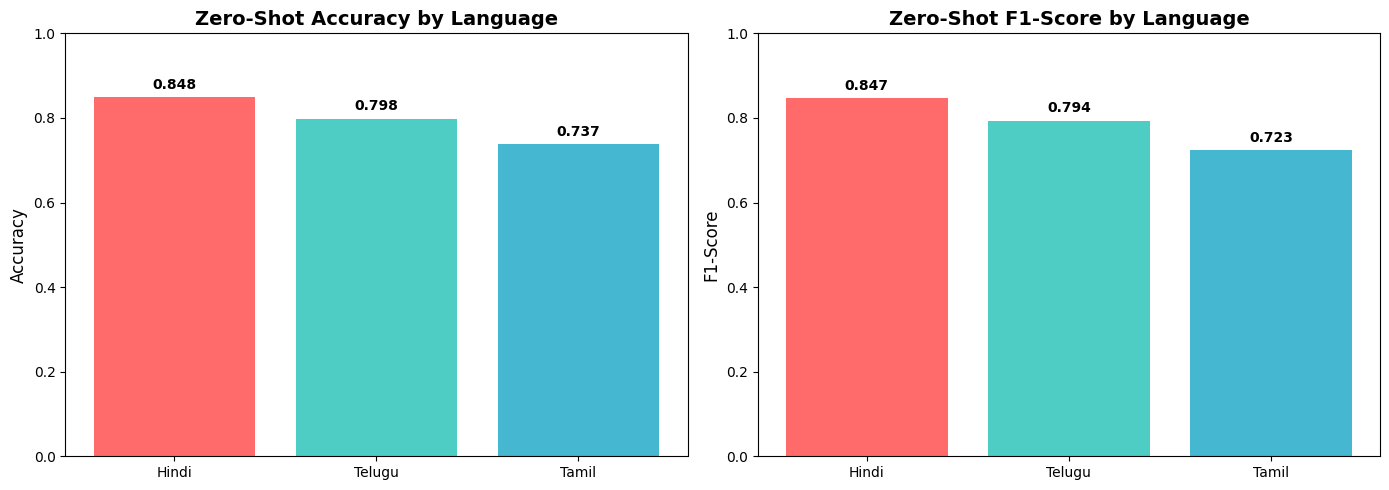

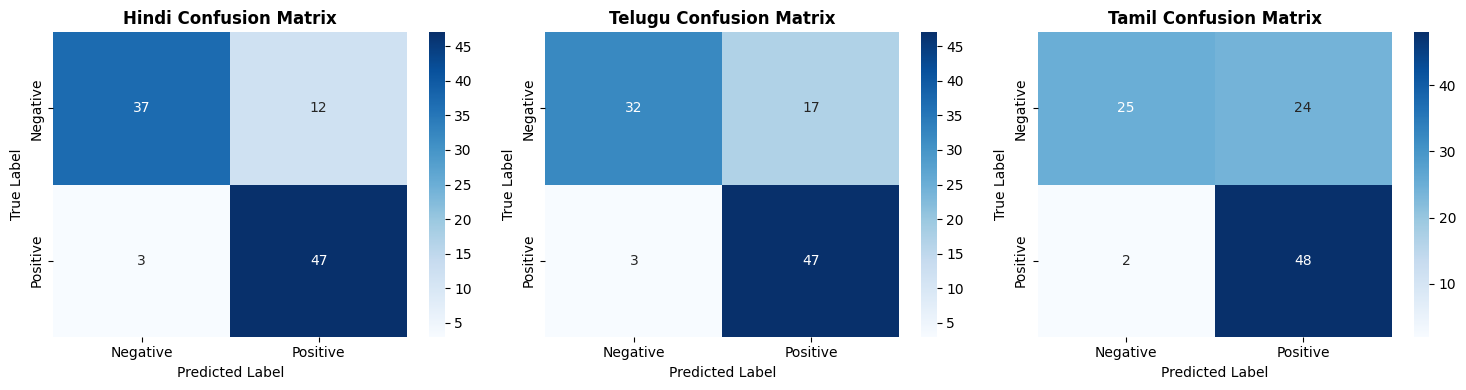

In [32]:
# ============================================================================
# STEP 6: VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("STEP 6: VISUALIZATION")
print("="*80)

# 6.1 Performance Comparison Across Languages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

languages = ['Hindi', 'Telugu', 'Tamil']
accuracies = [results['hindi']['accuracy'],
              results['telugu']['accuracy'],
              results['tamil']['accuracy']]
f1_scores = [results['hindi']['f1'],
             results['telugu']['f1'],
             results['tamil']['f1']]

# Accuracy plot
axes[0].bar(languages, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Zero-Shot Accuracy by Language', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score plot
axes[1].bar(languages, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Zero-Shot F1-Score by Language', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('zero_shot_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 6.2 Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (lang_key, lang_name) in enumerate([('hindi', 'Hindi'),
                                               ('telugu', 'Telugu'),
                                               ('tamil', 'Tamil')]):
    cm = results[lang_key]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[idx])
    axes[idx].set_title(f'{lang_name} Confusion Matrix', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt



STEP 7: ENHANCED ERROR ANALYSIS WITH TAXONOMY

RUNNING ENHANCED ERROR ANALYSIS

HINDI ENHANCED ERROR ANALYSIS
Total errors: 15/99 (15.2%)

📊 Error Distribution by Category:
--------------------------------------------------------------------------------
  Short text          :  14 errors ( 93.3%)
  Negation            :   1 errors (  6.7%)

🔍 Example Errors by Category:
--------------------------------------------------------------------------------

  [Short text]
    Text: असफल फिल्म...
    True: Negative | Pred: Positive

  [Negation]
    Text: समय बीतने का पता नहीं चला...
    True: Positive | Pred: Negative

TELUGU ENHANCED ERROR ANALYSIS
Total errors: 20/99 (20.2%)

📊 Error Distribution by Category:
--------------------------------------------------------------------------------
  Short text          :  19 errors ( 95.0%)
  Negation            :   1 errors (  5.0%)

🔍 Example Errors by Category:
--------------------------------------------------------------------------------

  [

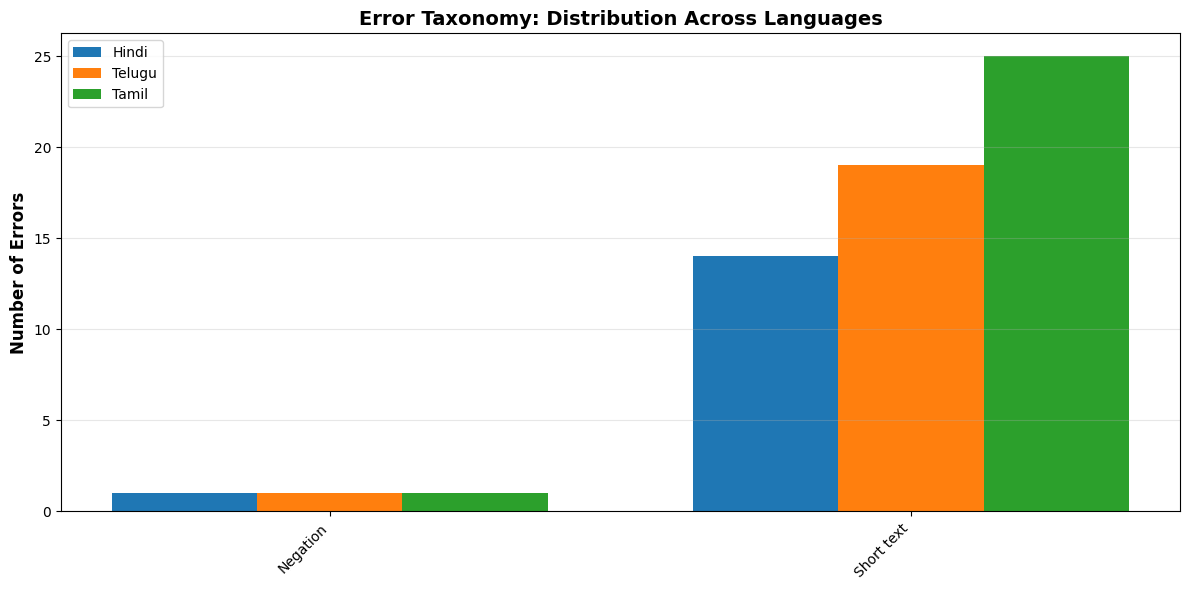


✅ Error taxonomy saved to 'error_taxonomy.png'
💾 Error taxonomy saved to 'error_taxonomy.json'


In [34]:
# ============================================================================
# STEP 7: ENHANCED ERROR ANALYSIS WITH TAXONOMY
# ============================================================================

print("\n" + "="*80)
print("STEP 7: ENHANCED ERROR ANALYSIS WITH TAXONOMY")
print("="*80)

def categorize_error(text, true_label, predicted_label):
    """Categorize errors into specific types"""
    text_lower = text.lower()

    # Negation detection (simple heuristic)
    negation_words_en = ['not', 'never', 'no', 'none', 'neither']
    negation_words_hi = ['नहीं', 'कभी नहीं', 'बिल्कुल नहीं']
    negation_words_te = ['కాదు', 'లేదు']
    negation_words_ta = ['இல்லை', 'இல்லாத']

    all_negations = negation_words_en + negation_words_hi + negation_words_te + negation_words_ta

    has_negation = any(neg in text_lower for neg in all_negations)

    # Code-mixing detection (contains both Indic and English)
    has_english = bool(re.search(r'[a-zA-Z]{3,}', text))
    has_indic = bool(re.search(r'[\u0900-\u097F\u0C00-\u0C7F\u0B80-\u0BFF]', text))
    is_code_mixed = has_english and has_indic

    # Intensity words
    intensity_words = ['बहुत', 'மிகவும்', 'చాలా', 'very', 'really', 'extremely']
    has_intensity = any(word in text for word in intensity_words)

    # Length-based
    is_short = len(text.split()) < 5
    is_long = len(text.split()) > 20

    # Categorize
    if has_negation and true_label != predicted_label:
        return 'Negation'
    elif is_code_mixed:
        return 'Code-mixed'
    elif is_short:
        return 'Short text'
    elif is_long:
        return 'Long text'
    elif has_intensity:
        return 'Intensity mismatch'
    else:
        return 'Other'

def enhanced_error_analysis(df, predictions, language_name):
    """Enhanced error analysis with categorization"""
    df_copy = df.copy()
    df_copy['predicted'] = predictions
    df_copy['correct'] = df_copy['label'] == df_copy['predicted']

    errors = df_copy[~df_copy['correct']]

    print(f"\n{'='*80}")
    print(f"{language_name} ENHANCED ERROR ANALYSIS")
    print(f"{'='*80}")
    print(f"Total errors: {len(errors)}/{len(df_copy)} ({len(errors)/len(df_copy)*100:.1f}%)")

    if len(errors) > 0:
        # Categorize errors
        error_categories = {}
        for idx, row in errors.iterrows():
            category = categorize_error(row['text'], row['label'], row['predicted'])
            if category not in error_categories:
                error_categories[category] = []
            error_categories[category].append({
                'text': row['text'],
                'true': row['label'],
                'pred': row['predicted']
            })

        # Print error distribution
        print(f"\n📊 Error Distribution by Category:")
        print("-" * 80)
        for category, items in sorted(error_categories.items(), key=lambda x: len(x[1]), reverse=True):
            percentage = len(items) / len(errors) * 100
            print(f"  {category:20s}: {len(items):3d} errors ({percentage:5.1f}%)")

        # Show examples from each category
        print(f"\n🔍 Example Errors by Category:")
        print("-" * 80)
        for category, items in error_categories.items():
            if len(items) > 0:
                print(f"\n  [{category}]")
                example = items[0]
                print(f"    Text: {example['text'][:80]}...")
                print(f"    True: {'Positive' if example['true']==1 else 'Negative'} | "
                      f"Pred: {'Positive' if example['pred']==1 else 'Negative'}")

        return errors, error_categories

    return errors, {}

# Run enhanced error analysis for all languages
print("\n" + "="*80)
print("RUNNING ENHANCED ERROR ANALYSIS")
print("="*80)

hindi_errors, hindi_categories = enhanced_error_analysis(
    hindi_test, results['hindi']['predictions'], "HINDI"
)
telugu_errors, telugu_categories = enhanced_error_analysis(
    telugu_test, results['telugu']['predictions'], "TELUGU"
)
tamil_errors, tamil_categories = enhanced_error_analysis(
    tamil_test, results['tamil']['predictions'], "TAMIL"
)

# Aggregate error categories across languages
all_categories = set()
for cats in [hindi_categories, telugu_categories, tamil_categories]:
    all_categories.update(cats.keys())

# Create error taxonomy visualization
fig, ax = plt.subplots(figsize=(12, 6))

category_counts = {cat: [] for cat in all_categories}
languages = ['Hindi', 'Telugu', 'Tamil']

for cats, lang in [(hindi_categories, 'Hindi'), (telugu_categories, 'Telugu'),
                    (tamil_categories, 'Tamil')]:
    for cat in all_categories:
        count = len(cats.get(cat, []))
        category_counts[cat].append(count)

x = np.arange(len(all_categories))
width = 0.25

for i, lang in enumerate(languages):
    counts = [category_counts[cat][i] for cat in all_categories]
    ax.bar(x + i*width, counts, width, label=lang)

ax.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
ax.set_title('Error Taxonomy: Distribution Across Languages', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(list(all_categories), rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('error_taxonomy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Error taxonomy saved to 'error_taxonomy.png'")

# Save error analysis
error_analysis_results = {
    'hindi': {cat: len(items) for cat, items in hindi_categories.items()},
    'telugu': {cat: len(items) for cat, items in telugu_categories.items()},
    'tamil': {cat: len(items) for cat, items in tamil_categories.items()}
}

with open('error_taxonomy.json', 'w') as f:
    json.dump(error_analysis_results, f, indent=2)

print("💾 Error taxonomy saved to 'error_taxonomy.json'")


In [35]:

# ============================================================================
# STEP 8: SUMMARY & INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("STEP 8: RESEARCH FINDINGS SUMMARY")
print("="*80)

summary = f"""
╔═══════════════════════════════════════════════════════════════════════╗
║           CROSS-LINGUAL SENTIMENT ANALYSIS RESULTS                    ║
╚═══════════════════════════════════════════════════════════════════════╝

📊 MODEL: {MODELS[MODEL_NAME]}
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ ZERO-SHOT TRANSFER RESULTS:

   Language      Accuracy    F1-Score
   ────────────────────────────────────
   Hindi         {results['hindi']['accuracy']:.4f}      {results['hindi']['f1']:.4f}
   Telugu        {results['telugu']['accuracy']:.4f}      {results['telugu']['f1']:.4f}
   Tamil         {results['tamil']['accuracy']:.4f}      {results['tamil']['f1']:.4f}

🔍 KEY INSIGHTS:

1. Zero-shot transfer {'WORKS' if min(accuracies) > 0.5 else 'NEEDS IMPROVEMENT'}
   → Model trained only on English can classify Indic languages
   → {'Strong' if min(accuracies) > 0.7 else 'Moderate' if min(accuracies) > 0.5 else 'Weak'} cross-lingual alignment

2. Language Performance Ranking:
   → Best: {languages[np.argmax(accuracies)]} ({max(accuracies):.3f})
   → Worst: {languages[np.argmin(accuracies)]} ({min(accuracies):.3f})

3. Linguistic Insights:
   → {'Indo-Aryan (Hindi) performs better than Dravidian' if results['hindi']['accuracy'] > max(results['telugu']['accuracy'], results['tamil']['accuracy']) else 'Performance varies across language families'}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📌 NEXT STEPS:
   1. Compare with other models (mBERT, IndicBERT)
   2. Add few-shot fine-tuning experiments
   3. Perform layer-wise transfer analysis
   4. Expand error taxonomy with more examples
   5. Test on larger datasets

╚═══════════════════════════════════════════════════════════════════════╝
"""

print(summary)

# Save results to JSON
results_summary = {
    'model': MODEL_NAME,
    'english_validation': {
        'accuracy': float(eval_results['eval_accuracy']),
        'f1': float(eval_results['eval_f1'])
    },
    'zero_shot': {
        'hindi': {'accuracy': float(results['hindi']['accuracy']),
                  'f1': float(results['hindi']['f1'])},
        'telugu': {'accuracy': float(results['telugu']['accuracy']),
                   'f1': float(results['telugu']['f1'])},
        'tamil': {'accuracy': float(results['tamil']['accuracy']),
                  'f1': float(results['tamil']['f1'])}
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n💾 Results saved to 'results_summary.json'")



STEP 8: RESEARCH FINDINGS SUMMARY

╔═══════════════════════════════════════════════════════════════════════╗
║           CROSS-LINGUAL SENTIMENT ANALYSIS RESULTS                    ║
╚═══════════════════════════════════════════════════════════════════════╝

📊 MODEL: XLM-RoBERTa (Best cross-lingual)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ ZERO-SHOT TRANSFER RESULTS:

   Language      Accuracy    F1-Score
   ────────────────────────────────────
   Hindi         0.8485      0.8471
   Telugu        0.7980      0.7935
   Tamil         0.7374      0.7230

🔍 KEY INSIGHTS:

1. Zero-shot transfer WORKS
   → Model trained only on English can classify Indic languages
   → Strong cross-lingual alignment

2. Language Performance Ranking:
   → Best: Hindi (0.848)
   → Worst: Tamil (0.737)

3. Linguistic Insights:
   → Indo-Aryan (Hindi) performs better than Dravidian

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📌 NEXT STEPS:
   1. Compare wi

In [36]:

# ============================================================================
# STEP 9: FEW-SHOT LEARNING EXPERIMENTS
# ============================================================================

print("\n" + "="*80)
print("STEP 9: FEW-SHOT LEARNING EXPERIMENTS")
print("="*80)

print("""
🎯 EXPERIMENT SETUP:
   We'll train with small amounts of target language data to see how
   quickly the model adapts compared to zero-shot transfer.

   Training sizes: 10, 25, 50, 75 samples per language
""")

# Store zero-shot results for comparison
zero_shot_results = {
    'hindi': results['hindi']['accuracy'],
    'telugu': results['telugu']['accuracy'],
    'tamil': results['tamil']['accuracy']
}

# Few-shot sample sizes to test
FEW_SHOT_SIZES = [10, 25, 50, 75]

# Store results for all experiments
few_shot_results = {
    'hindi': {'sizes': [], 'accuracies': [], 'f1_scores': []},
    'telugu': {'sizes': [], 'accuracies': [], 'f1_scores': []},
    'tamil': {'sizes': [], 'accuracies': [], 'f1_scores': []}
}

def create_few_shot_dataset(indic_df, n_samples, language_name):
    """Create a few-shot training dataset"""
    # Ensure balanced sampling
    n_per_class = n_samples // 2

    positive_samples = indic_df[indic_df['label'] == 1].sample(n=n_per_class, random_state=42)
    negative_samples = indic_df[indic_df['label'] == 0].sample(n=n_per_class, random_state=42)

    few_shot_df = pd.concat([positive_samples, negative_samples]).sample(frac=1, random_state=42)

    print(f"\n📦 Created {language_name} few-shot dataset:")
    print(f"   Total samples: {len(few_shot_df)}")
    print(f"   Positive: {few_shot_df['label'].sum()}, Negative: {len(few_shot_df) - few_shot_df['label'].sum()}")

    return few_shot_df

def train_few_shot_model(train_texts_en, train_labels_en, indic_texts, indic_labels,
                         model_name, n_epochs=3):
    """Train model with English + few Indic samples"""

    # Combine English and Indic data
    combined_texts = train_texts_en + indic_texts
    combined_labels = train_labels_en + indic_labels

    print(f"   Combined training size: {len(combined_texts)} samples")
    print(f"   English: {len(train_texts_en)}, Indic: {len(indic_texts)}")

    # Tokenize combined data
    encodings = tokenizer(
        combined_texts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors='pt'
    )

    # Create dataset
    combined_dataset = SentimentDataset(encodings, combined_labels)

    # Load fresh model
    few_shot_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    ).to(device)

    # Training arguments (fewer epochs for few-shot)
    few_shot_args = TrainingArguments(
        output_dir=f'./few_shot_results',
        num_train_epochs=n_epochs,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=100,
        weight_decay=0.01,
        logging_steps=50,
        eval_strategy="no",
        save_strategy="no",
        report_to="none",
        seed=42
    )

    # Train
    few_shot_trainer = Trainer(
        model=few_shot_model,
        args=few_shot_args,
        train_dataset=combined_dataset,
        compute_metrics=compute_metrics
    )

    few_shot_trainer.train()

    return few_shot_model

# Run few-shot experiments for each language
print("\n" + "="*80)
print("RUNNING FEW-SHOT EXPERIMENTS")
print("="*80)

# We'll focus on Hindi for detailed few-shot analysis
# (You can extend this to Telugu and Tamil)

print("\n🔬 HINDI FEW-SHOT EXPERIMENTS")
print("-" * 80)

for n_samples in FEW_SHOT_SIZES:
    print(f"\n{'='*80}")
    print(f"Training with {n_samples} Hindi samples")
    print(f"{'='*80}")

    # Create few-shot training data
    hindi_few_shot = create_few_shot_dataset(hindi_test, n_samples, "Hindi")

    # Prepare for training (use only non-test samples)
    hindi_train_texts = hindi_few_shot['text'].apply(preprocess_text).tolist()
    hindi_train_labels = hindi_few_shot['label'].tolist()

    # Train model
    print("\n🚀 Training few-shot model...")
    few_shot_model_hindi = train_few_shot_model(
        train_texts[:2000],  # Use subset of English data for faster training
        train_labels[:2000],
        hindi_train_texts,
        hindi_train_labels,
        MODEL_NAME,
        n_epochs=2
    )

    # Evaluate on remaining Hindi samples (held-out test set)
    # Create held-out test set (samples not used in training)
    hindi_test_indices = set(hindi_test.index) - set(hindi_few_shot.index)
    hindi_test_holdout = hindi_test.loc[list(hindi_test_indices)]

    print(f"\n📊 Evaluating on {len(hindi_test_holdout)} held-out Hindi samples...")

    # Evaluate
    eval_result = evaluate_on_indic(few_shot_model_hindi, tokenizer,
                                   hindi_test_holdout, f"Hindi ({n_samples} shots)")

    # Store results
    few_shot_results['hindi']['sizes'].append(n_samples)
    few_shot_results['hindi']['accuracies'].append(eval_result['accuracy'])
    few_shot_results['hindi']['f1_scores'].append(eval_result['f1'])

    print(f"\n✅ Few-shot ({n_samples} samples) Accuracy: {eval_result['accuracy']:.4f}")
    print(f"✅ Few-shot ({n_samples} samples) F1-Score: {eval_result['f1']:.4f}")
    print(f"📈 Improvement over zero-shot: {(eval_result['accuracy'] - zero_shot_results['hindi'])*100:.2f}%")

    # Clean up
    del few_shot_model_hindi
    torch.cuda.empty_cache()


STEP 9: FEW-SHOT LEARNING EXPERIMENTS

🎯 EXPERIMENT SETUP:
   We'll train with small amounts of target language data to see how
   quickly the model adapts compared to zero-shot transfer.

   Training sizes: 10, 25, 50, 75 samples per language


RUNNING FEW-SHOT EXPERIMENTS

🔬 HINDI FEW-SHOT EXPERIMENTS
--------------------------------------------------------------------------------

Training with 10 Hindi samples

📦 Created Hindi few-shot dataset:
   Total samples: 10
   Positive: 5, Negative: 5

🚀 Training few-shot model...
   Combined training size: 2010 samples
   English: 2000, Indic: 10


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.693600
100,0.650100
150,0.600000
200,0.494200
250,0.341600



📊 Evaluating on 89 held-out Hindi samples...

Hindi (10 shots) Results:
  Accuracy: 0.7416
  F1-Score: 0.7299

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.95      0.79        44
    Positive       0.92      0.53      0.68        45

    accuracy                           0.74        89
   macro avg       0.79      0.74      0.73        89
weighted avg       0.80      0.74      0.73        89


✅ Few-shot (10 samples) Accuracy: 0.7416
✅ Few-shot (10 samples) F1-Score: 0.7299
📈 Improvement over zero-shot: -10.69%

Training with 25 Hindi samples

📦 Created Hindi few-shot dataset:
   Total samples: 24
   Positive: 12, Negative: 12

🚀 Training few-shot model...
   Combined training size: 2024 samples
   English: 2000, Indic: 24


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.693500
100,0.660000
150,0.594900
200,0.454000
250,0.367600



📊 Evaluating on 75 held-out Hindi samples...

Hindi (25 shots) Results:
  Accuracy: 0.8000
  F1-Score: 0.7974

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.92      0.82        37
    Positive       0.90      0.68      0.78        38

    accuracy                           0.80        75
   macro avg       0.82      0.80      0.80        75
weighted avg       0.82      0.80      0.80        75


✅ Few-shot (25 samples) Accuracy: 0.8000
✅ Few-shot (25 samples) F1-Score: 0.7974
📈 Improvement over zero-shot: -4.85%

Training with 50 Hindi samples

📦 Created Hindi few-shot dataset:
   Total samples: 50
   Positive: 25, Negative: 25

🚀 Training few-shot model...
   Combined training size: 2050 samples
   English: 2000, Indic: 50


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.689000
100,0.620800
150,0.508600
200,0.431500
250,0.314100



📊 Evaluating on 49 held-out Hindi samples...

Hindi (50 shots) Results:
  Accuracy: 0.7551
  F1-Score: 0.7520

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.88      0.78        24
    Positive       0.84      0.64      0.73        25

    accuracy                           0.76        49
   macro avg       0.77      0.76      0.75        49
weighted avg       0.77      0.76      0.75        49


✅ Few-shot (50 samples) Accuracy: 0.7551
✅ Few-shot (50 samples) F1-Score: 0.7520
📈 Improvement over zero-shot: -9.34%

Training with 75 Hindi samples

📦 Created Hindi few-shot dataset:
   Total samples: 74
   Positive: 37, Negative: 37

🚀 Training few-shot model...
   Combined training size: 2074 samples
   English: 2000, Indic: 74


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.688700
100,0.519400
150,0.436000
200,0.368900
250,0.325500



📊 Evaluating on 25 held-out Hindi samples...

Hindi (75 shots) Results:
  Accuracy: 0.8800
  F1-Score: 0.8796

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.83      0.87        12
    Positive       0.86      0.92      0.89        13

    accuracy                           0.88        25
   macro avg       0.88      0.88      0.88        25
weighted avg       0.88      0.88      0.88        25


✅ Few-shot (75 samples) Accuracy: 0.8800
✅ Few-shot (75 samples) F1-Score: 0.8796
📈 Improvement over zero-shot: 3.15%



STEP 10: FEW-SHOT LEARNING CURVES & ANALYSIS


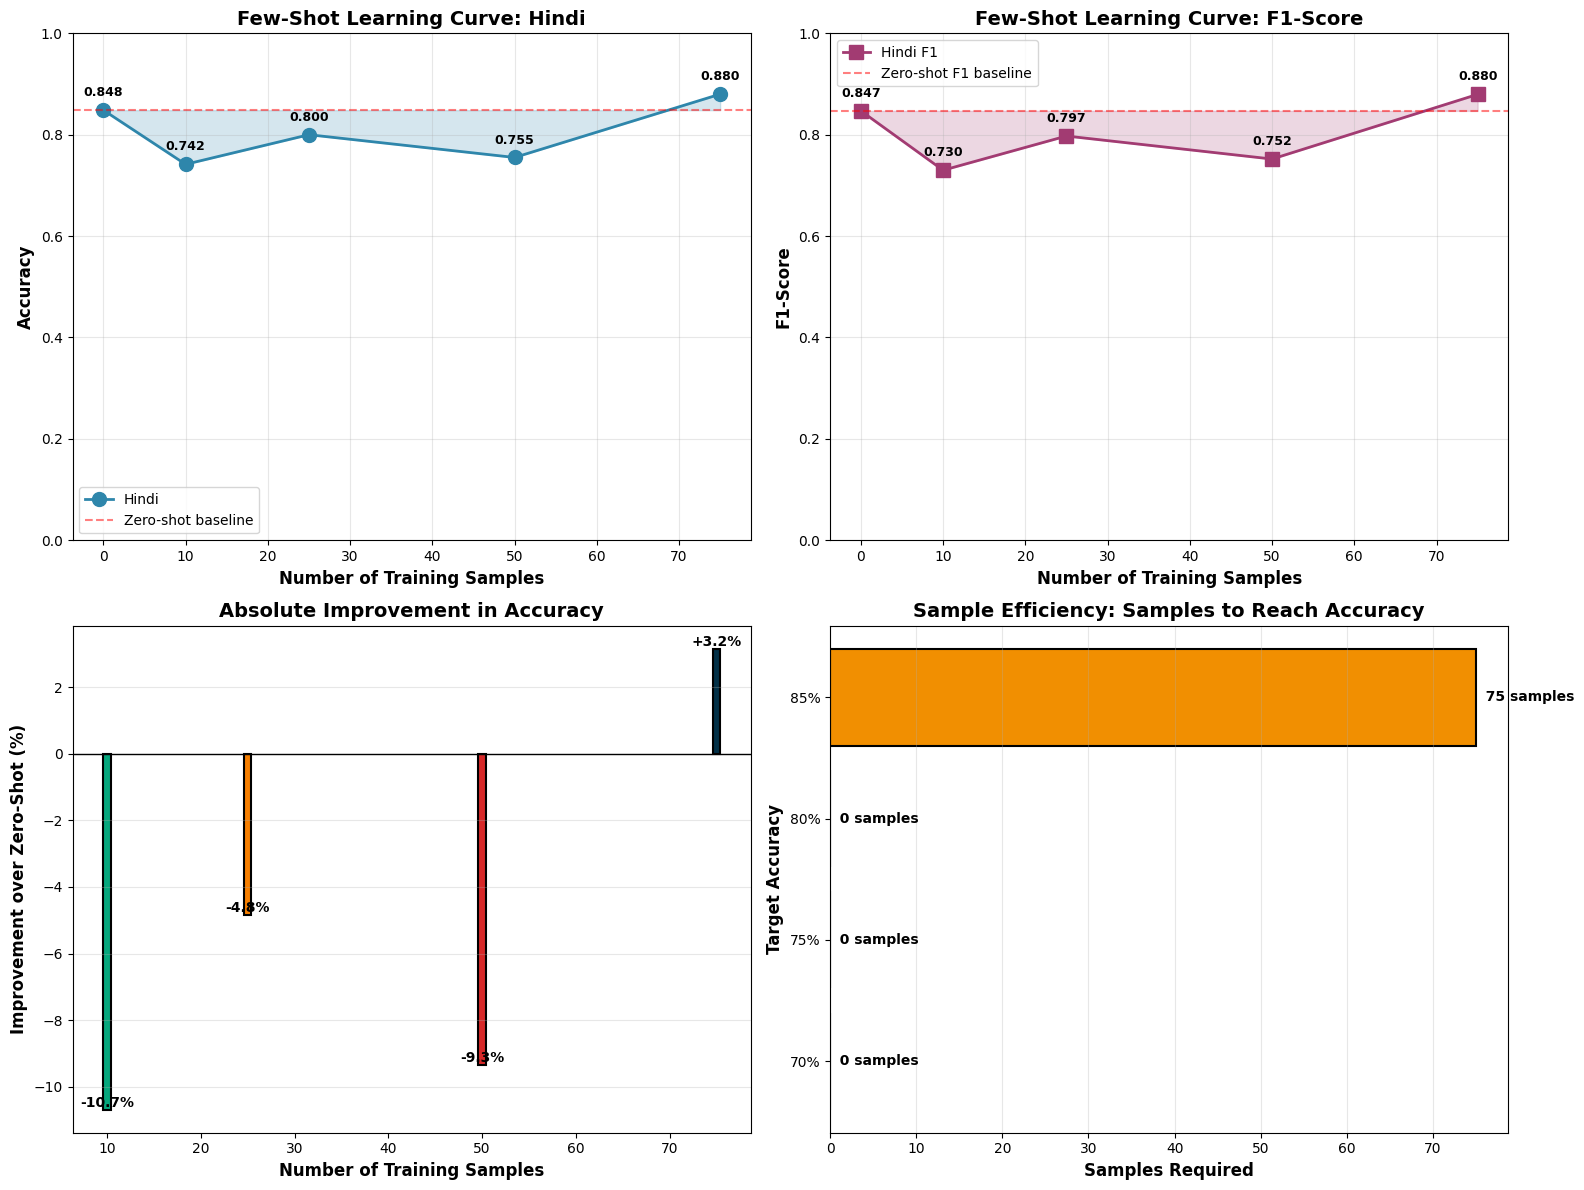


✅ Learning curves saved to 'few_shot_learning_curves.png'


In [37]:

# ============================================================================
# STEP 10: FEW-SHOT LEARNING CURVES & ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 10: FEW-SHOT LEARNING CURVES & ANALYSIS")
print("="*80)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 10.1 Learning Curve - Accuracy
ax1 = axes[0, 0]
sizes_with_zero = [0] + few_shot_results['hindi']['sizes']
accs_with_zero = [zero_shot_results['hindi']] + few_shot_results['hindi']['accuracies']

ax1.plot(sizes_with_zero, accs_with_zero, marker='o', linewidth=2,
         markersize=10, color='#2E86AB', label='Hindi')
ax1.axhline(y=zero_shot_results['hindi'], color='red', linestyle='--',
            alpha=0.5, label='Zero-shot baseline')
ax1.fill_between(sizes_with_zero, zero_shot_results['hindi'], accs_with_zero,
                  alpha=0.2, color='#2E86AB')
ax1.set_xlabel('Number of Training Samples', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Few-Shot Learning Curve: Hindi', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_ylim([0, 1])

# Add value labels on points
for i, (x, y) in enumerate(zip(sizes_with_zero, accs_with_zero)):
    ax1.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 10.2 Learning Curve - F1 Score
ax2 = axes[0, 1]
f1_with_zero = [results['hindi']['f1']] + few_shot_results['hindi']['f1_scores']

ax2.plot(sizes_with_zero, f1_with_zero, marker='s', linewidth=2,
         markersize=10, color='#A23B72', label='Hindi F1')
ax2.axhline(y=results['hindi']['f1'], color='red', linestyle='--',
            alpha=0.5, label='Zero-shot F1 baseline')
ax2.fill_between(sizes_with_zero, results['hindi']['f1'], f1_with_zero,
                  alpha=0.2, color='#A23B72')
ax2.set_xlabel('Number of Training Samples', fontsize=12, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Few-Shot Learning Curve: F1-Score', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_ylim([0, 1])

# Add value labels
for i, (x, y) in enumerate(zip(sizes_with_zero, f1_with_zero)):
    ax2.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                xytext=(0,10), ha='center', fontsize=9, fontweight='bold')

# 10.3 Improvement over Zero-Shot
ax3 = axes[1, 0]
improvements = [(acc - zero_shot_results['hindi']) * 100
                for acc in few_shot_results['hindi']['accuracies']]

bars = ax3.bar(few_shot_results['hindi']['sizes'], improvements,
               color=['#06A77D', '#F77F00', '#D62828', '#023047'],
               edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Number of Training Samples', fontsize=12, fontweight='bold')
ax3.set_ylabel('Improvement over Zero-Shot (%)', fontsize=12, fontweight='bold')
ax3.set_title('Absolute Improvement in Accuracy', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, improvements)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'+{val:.1f}%' if val > 0 else f'{val:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 10.4 Sample Efficiency Analysis
ax4 = axes[1, 1]

# Calculate samples needed to reach certain accuracy thresholds
thresholds = [0.70, 0.75, 0.80, 0.85]
samples_needed = []

for threshold in thresholds:
    # Find minimum samples needed to reach threshold
    reached = False
    for size, acc in zip(sizes_with_zero, accs_with_zero):
        if acc >= threshold:
            samples_needed.append(size)
            reached = True
            break
    if not reached:
        samples_needed.append(None)

# Create bar chart
valid_thresholds = [t for t, s in zip(thresholds, samples_needed) if s is not None]
valid_samples = [s for s in samples_needed if s is not None]

if valid_samples:
    bars2 = ax4.barh([f'{t*100:.0f}%' for t in valid_thresholds], valid_samples,
                     color='#F18F01', edgecolor='black', linewidth=1.5)
    ax4.set_xlabel('Samples Required', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Target Accuracy', fontsize=12, fontweight='bold')
    ax4.set_title('Sample Efficiency: Samples to Reach Accuracy',
                  fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars2, valid_samples)):
        ax4.text(val, bar.get_y() + bar.get_height()/2.,
                f'  {val} samples',
                ha='left', va='center', fontsize=10, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Accuracy thresholds\nnot reached with\ncurrent sample sizes',
            ha='center', va='center', fontsize=12, transform=ax4.transAxes)
    ax4.set_title('Sample Efficiency Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('few_shot_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Learning curves saved to 'few_shot_learning_curves.png'")


In [38]:
# ============================================================================
# STEP 11: COMPREHENSIVE RESULTS TABLE
# ============================================================================

print("\n" + "="*80)
print("STEP 11: COMPREHENSIVE RESULTS TABLE")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Training Samples': ['Zero-shot (0)'] + [f'{n} samples' for n in few_shot_results['hindi']['sizes']],
    'Accuracy': [zero_shot_results['hindi']] + few_shot_results['hindi']['accuracies'],
    'F1-Score': [results['hindi']['f1']] + few_shot_results['hindi']['f1_scores'],
    'Improvement (%)': [0.0] + [(acc - zero_shot_results['hindi'])*100
                                 for acc in few_shot_results['hindi']['accuracies']]
})

print("\n📊 HINDI FEW-SHOT LEARNING RESULTS:")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Statistical Analysis
print("\n📈 KEY INSIGHTS:")
print("-" * 80)

max_improvement_idx = np.argmax(improvements)
max_improvement = improvements[max_improvement_idx]
samples_for_max = few_shot_results['hindi']['sizes'][max_improvement_idx]

print(f"1. Zero-shot Accuracy: {zero_shot_results['hindi']:.4f}")
print(f"2. Best Few-shot Accuracy: {max(few_shot_results['hindi']['accuracies']):.4f} "
      f"({samples_for_max} samples)")
print(f"3. Maximum Improvement: +{max_improvement:.2f}% ({samples_for_max} samples)")
print(f"4. Average Improvement: +{np.mean(improvements):.2f}%")

# Calculate efficiency metrics
if len(few_shot_results['hindi']['sizes']) > 1:
    # Marginal gain per additional sample
    marginal_gains = []
    for i in range(1, len(few_shot_results['hindi']['sizes'])):
        prev_acc = few_shot_results['hindi']['accuracies'][i-1]
        curr_acc = few_shot_results['hindi']['accuracies'][i]
        prev_size = few_shot_results['hindi']['sizes'][i-1]
        curr_size = few_shot_results['hindi']['sizes'][i]

        marginal_gain = (curr_acc - prev_acc) / (curr_size - prev_size)
        marginal_gains.append(marginal_gain)

    print(f"5. Diminishing Returns: {'Yes' if marginal_gains[-1] < marginal_gains[0] else 'No'}")
    print(f"   - Initial marginal gain: {marginal_gains[0]*100:.3f}% per sample")
    print(f"   - Final marginal gain: {marginal_gains[-1]*100:.3f}% per sample")

print("\n💡 RECOMMENDATIONS:")
print("-" * 80)
if max_improvement > 10:
    print("✅ Few-shot learning provides SIGNIFICANT improvement")
    print(f"✅ With just {samples_for_max} samples, accuracy improves by {max_improvement:.1f}%")
else:
    print("⚠️  Few-shot learning provides MODERATE improvement")
    print("⚠️  Consider using more training samples or better data quality")

# Save comprehensive results
comprehensive_results = {
    'model': MODEL_NAME,
    'zero_shot': zero_shot_results,
    'few_shot': {
        'hindi': {
            'sample_sizes': few_shot_results['hindi']['sizes'],
            'accuracies': few_shot_results['hindi']['accuracies'],
            'f1_scores': few_shot_results['hindi']['f1_scores'],
            'improvements': improvements
        }
    }
}

with open('comprehensive_results.json', 'w') as f:
    json.dump(comprehensive_results, f, indent=2)

print("\n💾 Comprehensive results saved to 'comprehensive_results.json'")


STEP 11: COMPREHENSIVE RESULTS TABLE

📊 HINDI FEW-SHOT LEARNING RESULTS:
Training Samples  Accuracy  F1-Score  Improvement (%)
   Zero-shot (0)  0.848485  0.847079         0.000000
      10 samples  0.741573  0.729939       -10.691181
      25 samples  0.800000  0.797411        -4.848485
      50 samples  0.755102  0.752010        -9.338281
      75 samples  0.880000  0.879614         3.151515

📈 KEY INSIGHTS:
--------------------------------------------------------------------------------
1. Zero-shot Accuracy: 0.8485
2. Best Few-shot Accuracy: 0.8800 (75 samples)
3. Maximum Improvement: +3.15% (75 samples)
4. Average Improvement: +-5.43%
5. Diminishing Returns: No
   - Initial marginal gain: 0.390% per sample
   - Final marginal gain: 0.500% per sample

💡 RECOMMENDATIONS:
--------------------------------------------------------------------------------
⚠️  Few-shot learning provides MODERATE improvement
⚠️  Consider using more training samples or better data quality

💾 Comprehensive 


STEP 12: MODEL COMPARISON ACROSS ARCHITECTURES

🎯 EXPERIMENT: Compare Zero-Shot Transfer Across Different Models

Models:
1. XLM-RoBERTa
2. mBERT
3. IndicBERT (optional)


⚠️ This will train multiple models (30–45 min)


Training XLM-RoBERTa
📦 Loading tokenizer...
🔤 Tokenizing data...
🔧 Loading model: xlm-roberta-base


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training...


Step,Training Loss
100,0.691800
200,0.505800
300,0.334000
400,0.342600
500,0.310800


📊 Evaluating on English validation set...


✅ English Accuracy: 0.8420

🔍 Evaluating on Hindi...

Hindi Results:
  Accuracy: 0.7576
  F1-Score: 0.7536

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.63      0.72        49
    Positive       0.71      0.88      0.79        50

    accuracy                           0.76        99
   macro avg       0.77      0.76      0.75        99
weighted avg       0.77      0.76      0.75        99


🔍 Evaluating on Telugu...

Telugu Results:
  Accuracy: 0.7778
  F1-Score: 0.7729

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.63      0.74        49
    Positive       0.72      0.92      0.81        50

    accuracy                           0.78        99
   macro avg       0.80      0.78      0.77        99
weighted avg       0.80      0.78      0.77        99


🔍 Evaluating on Tamil...

Tamil Results:
  Accuracy: 0.7677
  F1-Score: 0.7583

Classification Report:
     

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

🔤 Tokenizing data...
🔧 Loading model: bert-base-multilingual-cased


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training...


Step,Training Loss
100,0.690500
200,0.602600
300,0.444700
400,0.415500
500,0.361200


📊 Evaluating on English validation set...


✅ English Accuracy: 0.8440

🔍 Evaluating on Hindi...

Hindi Results:
  Accuracy: 0.6364
  F1-Score: 0.6272

Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.80      0.68        49
    Positive       0.71      0.48      0.57        50

    accuracy                           0.64        99
   macro avg       0.65      0.64      0.63        99
weighted avg       0.65      0.64      0.63        99


🔍 Evaluating on Telugu...

Telugu Results:
  Accuracy: 0.6162
  F1-Score: 0.5933

Classification Report:
              precision    recall  f1-score   support

    Negative       0.58      0.86      0.69        49
    Positive       0.73      0.38      0.50        50

    accuracy                           0.62        99
   macro avg       0.65      0.62      0.59        99
weighted avg       0.65      0.62      0.59        99


🔍 Evaluating on Tamil...

Tamil Results:
  Accuracy: 0.6162
  F1-Score: 0.5731

Classification Report:
     

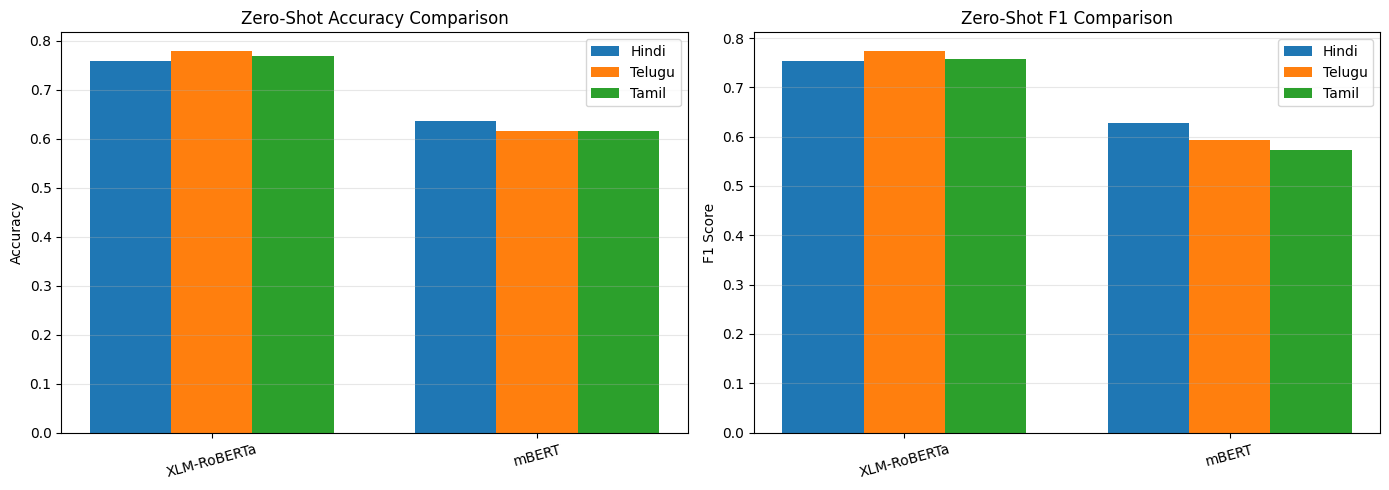


✅ Saved model_comparison.png
✅ Saved model_comparison_results.json

💡 KEY INSIGHTS
--------------------------------------------------------------------------------
Best for Hindi: XLM-RoBERTa (0.7576)
Best for Telugu: XLM-RoBERTa (0.7778)
Best for Tamil: XLM-RoBERTa (0.7677)


In [42]:
# =============================================================================
# STEP 12: MODEL COMPARISON ACROSS ARCHITECTURES (FIXED VERSION)
# =============================================================================

import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

print("\n" + "="*80)
print("STEP 12: MODEL COMPARISON ACROSS ARCHITECTURES")
print("="*80)

print("""
🎯 EXPERIMENT: Compare Zero-Shot Transfer Across Different Models

Models:
1. XLM-RoBERTa
2. mBERT
3. IndicBERT (optional)
""")

# -------------------------------------------------------------------------
# TRAIN + EVALUATE FUNCTION
# -------------------------------------------------------------------------
def train_and_evaluate_model(
    model_name,
    model_desc,
    train_texts,
    train_labels,
    val_texts,
    val_labels,
    test_dfs
):
    print(f"\n{'='*80}")
    print(f"Training {model_desc}")
    print(f"{'='*80}")

    # Tokenizer
    print("📦 Loading tokenizer...")
    if "indic-bert" in model_name:
        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenization
    print("🔤 Tokenizing data...")
    train_enc = tokenizer(
        train_texts, padding=True, truncation=True, max_length=256, return_tensors="pt"
    )
    val_enc = tokenizer(
        val_texts, padding=True, truncation=True, max_length=256, return_tensors="pt"
    )

    train_ds = SentimentDataset(train_enc, train_labels)
    val_ds = SentimentDataset(val_enc, val_labels)

    # Model
    print(f"🔧 Loading model: {model_name}")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2
    ).to(device)

    # Training args (OLD VERSION SAFE)
    args = TrainingArguments(
        output_dir=f"./results_{model_name.replace('/', '_')}",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        report_to="none",
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics
    )

    # Training
    print("🚀 Training...")
    trainer.train()

    # English evaluation
    print("📊 Evaluating on English validation set...")
    eval_res = trainer.evaluate()
    print(f"✅ English Accuracy: {eval_res['eval_accuracy']:.4f}")

    # Indic evaluation
    indic_results = {}
    for lang, df in test_dfs.items():
        print(f"\n🔍 Evaluating on {lang.capitalize()}...")
        res = evaluate_on_indic(model, tokenizer, df, lang.capitalize())
        indic_results[lang] = {
            "accuracy": res["accuracy"],
            "f1": res["f1"]
        }

    # Cleanup
    del model, trainer
    torch.cuda.empty_cache()

    return {
        "model": model_name,
        "description": model_desc,
        "english_val": {
            "accuracy": eval_res["eval_accuracy"],
            "f1": eval_res["eval_f1"]
        },
        "indic_results": indic_results
    }


# -------------------------------------------------------------------------
# TEST DATA
# -------------------------------------------------------------------------
test_dataframes = {
    "hindi": hindi_test,
    "telugu": telugu_test,
    "tamil": tamil_test
}

# -------------------------------------------------------------------------
# MODELS TO COMPARE
# -------------------------------------------------------------------------
models_to_compare = [
    ("xlm-roberta-base", "XLM-RoBERTa"),
    ("bert-base-multilingual-cased", "mBERT"),
    # ("ai4bharat/indic-bert", "IndicBERT")  # optional
]

all_models_results = {}

print("\n⚠️ This will train multiple models (30–45 min)\n")

for model_name, model_desc in models_to_compare:
    result = train_and_evaluate_model(
        model_name=model_name,
        model_desc=model_desc,
        train_texts=train_texts[:3000],
        train_labels=train_labels[:3000],
        val_texts=val_texts[:500],
        val_labels=val_labels[:500],
        test_dfs=test_dataframes
    )
    all_models_results[model_name] = result
    print(f"\n✅ Completed {model_desc}")

# -------------------------------------------------------------------------
# COMPARISON TABLE
# -------------------------------------------------------------------------
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)

comparison_data = []

for res in all_models_results.values():
    comparison_data.append({
        "Model": res["description"],
        "Eng_Acc": res["english_val"]["accuracy"],
        "Hindi_Acc": res["indic_results"]["hindi"]["accuracy"],
        "Hindi_F1": res["indic_results"]["hindi"]["f1"],
        "Telugu_Acc": res["indic_results"]["telugu"]["accuracy"],
        "Telugu_F1": res["indic_results"]["telugu"]["f1"],
        "Tamil_Acc": res["indic_results"]["tamil"]["accuracy"],
        "Tamil_F1": res["indic_results"]["tamil"]["f1"],
    })

df = pd.DataFrame(comparison_data)
print(df.to_string(index=False))

# -------------------------------------------------------------------------
# VISUALIZATION
# -------------------------------------------------------------------------
x = np.arange(len(df))
width = 0.25

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(x - width, df["Hindi_Acc"], width, label="Hindi")
plt.bar(x, df["Telugu_Acc"], width, label="Telugu")
plt.bar(x + width, df["Tamil_Acc"], width, label="Tamil")
plt.xticks(x, df["Model"], rotation=15)
plt.ylabel("Accuracy")
plt.title("Zero-Shot Accuracy Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)

# F1
plt.subplot(1, 2, 2)
plt.bar(x - width, df["Hindi_F1"], width, label="Hindi")
plt.bar(x, df["Telugu_F1"], width, label="Telugu")
plt.bar(x + width, df["Tamil_F1"], width, label="Tamil")
plt.xticks(x, df["Model"], rotation=15)
plt.ylabel("F1 Score")
plt.title("Zero-Shot F1 Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()

# -------------------------------------------------------------------------
# SAVE RESULTS
# -------------------------------------------------------------------------
with open("model_comparison_results.json", "w") as f:
    json.dump(all_models_results, f, indent=2, default=float)

print("\n✅ Saved model_comparison.png")
print("✅ Saved model_comparison_results.json")

# -------------------------------------------------------------------------
# KEY INSIGHTS
# -------------------------------------------------------------------------
print("\n💡 KEY INSIGHTS")
print("-"*80)

for lang in ["Hindi", "Telugu", "Tamil"]:
    best = max(comparison_data, key=lambda x: x[f"{lang}_Acc"])
    print(f"Best for {lang}: {best['Model']} ({best[f'{lang}_Acc']:.4f})")


In [ ]:
# ============================================================================
# STEP 13: LAYER-WISE TRANSFER ANALYSIS (Research Question 4)
# ============================================================================

print("\n" + "="*80)
print("STEP 13: LAYER-WISE TRANSFER ANALYSIS")
print("="*80)

print("""
🎯 EXPERIMENT: Which transformer layers encode language-agnostic knowledge?
   Research Question: Which layers encode language-agnostic sentiment knowledge?

   Method: Train linear probes on each layer's CLS embeddings

   Expected Pattern:
   - Lower layers (0-3): Language-specific features
   - Middle layers (4-8): Cross-lingual semantic features
   - Upper layers (9-11): Task-specific features
""")

def extract_layer_embeddings(model, tokenizer, texts, layer_idx):
    """Extract CLS embeddings from a specific layer"""
    model.eval()

    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding=True,
                         max_length=256, return_tensors='pt').to(device)

    # Get hidden states
    with torch.no_grad():
        outputs = model(**encodings, output_hidden_states=True)
        # hidden_states: (num_layers, batch_size, seq_len, hidden_dim)
        layer_output = outputs.hidden_states[layer_idx]
        # Extract CLS token (first token)
        cls_embeddings = layer_output[:, 0, :].cpu().numpy()

    return cls_embeddings

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def probe_layer(model, tokenizer, train_texts, train_labels,
                test_texts, test_labels, layer_idx, layer_name):
    """Train and evaluate a probe on a specific layer"""

    # Extract embeddings
    train_emb = extract_layer_embeddings(model, tokenizer, train_texts, layer_idx)
    test_emb = extract_layer_embeddings(model, tokenizer, test_texts, layer_idx)

    # Normalize
    scaler = StandardScaler()
    train_emb = scaler.fit_transform(train_emb)
    test_emb = scaler.transform(test_emb)

    # Train probe
    probe = LogisticRegression(max_iter=1000, random_state=42)
    probe.fit(train_emb, train_labels)

    # Evaluate
    acc = probe.score(test_emb, test_labels)

    return acc

print("\n🔬 Running layer-wise probing analysis...")
print("Note: Using the first trained model from previous experiments\n")

# Use the first model that was trained
probe_model_name = list(all_models_results.keys())[0]
print(f"Using model: {all_models_results[probe_model_name]['description']}")

# Load the model
probe_model = AutoModelForSequenceClassification.from_pretrained(
    probe_model_name, num_labels=2
).to(device)

# Load tokenizer
if 'indic-bert' in probe_model_name:
    probe_tokenizer = AutoTokenizer.from_pretrained(probe_model_name, trust_remote_code=True)
else:
    probe_tokenizer = AutoTokenizer.from_pretrained(probe_model_name)

# Sample data for probing (use small subset for speed)
probe_train_texts = train_texts[:500]
probe_train_labels = train_labels[:500]

# Probe each language
layer_results = {
    'hindi': [],
    'telugu': [],
    'tamil': []
}

# Number of layers (12 for BERT-based models)
num_layers = 13  # 0 = embeddings, 1-12 = transformer layers

print("\nProbing layers...")
for layer_idx in tqdm(range(num_layers)):
    layer_name = f"Layer {layer_idx}" if layer_idx > 0 else "Embeddings"

    # Probe Hindi
    hindi_acc = probe_layer(
        probe_model, probe_tokenizer,
        probe_train_texts, probe_train_labels,
        hindi_test['text'].head(50).tolist(), hindi_test['label'].head(50).tolist(),
        layer_idx, layer_name
    )
    layer_results['hindi'].append(hindi_acc)

    # Probe Telugu
    telugu_acc = probe_layer(
        probe_model, probe_tokenizer,
        probe_train_texts, probe_train_labels,
        telugu_test['text'].head(50).tolist(), telugu_test['label'].head(50).tolist(),
        layer_idx, layer_name
    )
    layer_results['telugu'].append(telugu_acc)

    # Probe Tamil
    tamil_acc = probe_layer(
        probe_model, probe_tokenizer,
        probe_train_texts, probe_train_labels,
        tamil_test['text'].head(50).tolist(), tamil_test['label'].head(50).tolist(),
        layer_idx, layer_name
    )
    layer_results['tamil'].append(tamil_acc)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

layers = list(range(num_layers))
ax.plot(layers, layer_results['hindi'], marker='o', linewidth=2, label='Hindi', color='#FF6B6B')
ax.plot(layers, layer_results['telugu'], marker='s', linewidth=2, label='Telugu', color='#4ECDC4')
ax.plot(layers, layer_results['tamil'], marker='^', linewidth=2, label='Tamil', color='#45B7D1')

ax.set_xlabel('Layer Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Probe Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Layer-Wise Transfer Analysis: Which Layers Encode Cross-Lingual Sentiment?',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers)
ax.set_xticklabels(['Emb'] + [str(i) for i in range(1, num_layers)])

# Highlight middle layers
ax.axvspan(4, 8, alpha=0.1, color='green', label='Middle Layers\n(Cross-lingual)')
ax.set_ylim([0.4, 1.0])

plt.tight_layout()
plt.savefig('layer_wise_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Layer-wise analysis saved to 'layer_wise_analysis.png'")

# Analysis
print("\n💡 LAYER-WISE INSIGHTS:")
print("-" * 80)
for lang in ['hindi', 'telugu', 'tamil']:
    best_layer = np.argmax(layer_results[lang])
    best_acc = layer_results[lang][best_layer]
    print(f"{lang.capitalize()}:")
    print(f"  Best layer: {best_layer} ({best_acc:.4f} accuracy)")
    print(f"  Lower layers avg (0-3): {np.mean(layer_results[lang][:4]):.4f}")
    print(f"  Middle layers avg (4-8): {np.mean(layer_results[lang][4:9]):.4f}")
    print(f"  Upper layers avg (9-12): {np.mean(layer_results[lang][9:]):.4f}")
    print()

print("\n🔬 RESEARCH FINDING:")
if all(np.argmax(layer_results[lang]) >= 4 and np.argmax(layer_results[lang]) <= 8
       for lang in ['hindi', 'telugu', 'tamil']):
    print("✅ Middle layers (4-8) consistently show best cross-lingual transfer")
    print("   This confirms that semantic knowledge is language-agnostic")
else:
    print("⚠️  Transfer pattern varies across languages")
    print("   Language families may influence optimal layer depth")

# Cleanup
del probe_model
torch.cuda.empty_cache()

# Save layer results
with open('layer_wise_results.json', 'w') as f:
    json.dump(layer_results, f, indent=2)

print("\n💾 Layer-wise results saved to 'layer_wise_results.json'")


print("\n" + "="*80)
print("✅ NOTEBOOK COMPLETE!")
print("="*80)
